# EDA Customer Loans In Finance

## Aim
1. Gain deeper understanding about the data (outliers, skeweness, types of missing data, correlation)
2. Transform the data to ensure correct data types, ensure normal distribution, impute data
3. Analyse transformed loan data to identify patterns emerged and improve loan risk management

# Load Data

In [1]:
from db_utils import RDSDatabaseConnector, load_credentials
import matplotlib.pyplot as pyplot
from pandas.tseries.offsets import DateOffset


from format import DataFormat
import pandas as pd


from plotter import Plotter


from transform import DataFrameTransform


from db_utils import load_data


from info import DataFrameInfo


import numpy as np


import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)


# cred_dict = load_credentials()


# rds_con = RDSDatabaseConnector(cred_dict)


# df = rds_con.extract_rds_dataframe('loan_payments')


# RDSDatabaseConnector.save_to_csv(df, "loan_data.csv", index=False)


# RDSDatabaseConnector.csv_to_excel('loan_data')

## Check percentage of missing columns and Shape

Dataframe Shape:
(54231, 44)
                                % Null
funded_amount                 5.544799
term                          8.799395
int_rate                      9.531449
employment_length             3.905515
mths_since_last_delinq       57.166565
mths_since_last_record       88.602460
last_payment_date             0.134609
next_payment_date            60.127971
last_credit_pull_date         0.012908
collections_12_mths_ex_med    0.094042
mths_since_last_major_derog  86.172116


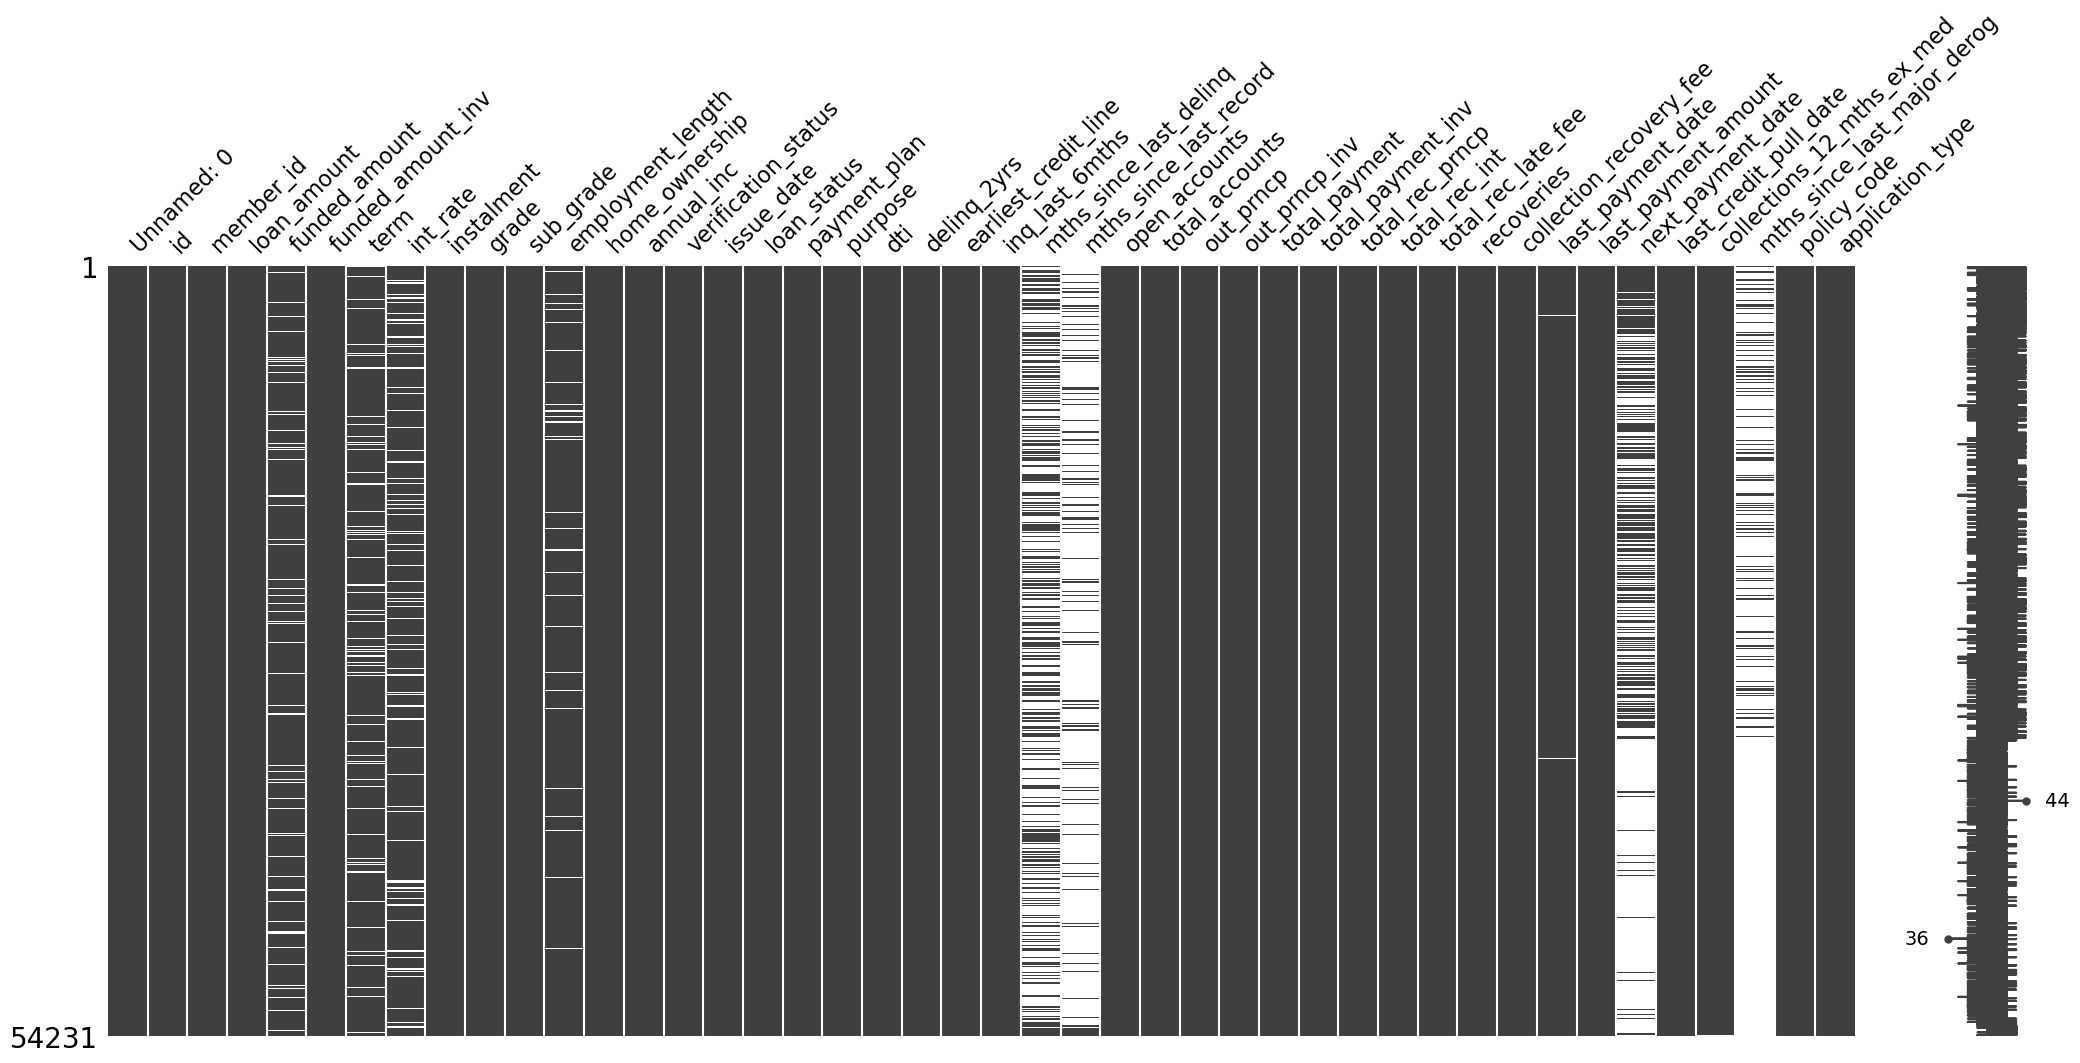

In [2]:
df = load_data("/dataset/loan_data.csv")
Info = DataFrameInfo(df)

print(Info.get_shape())
print(Info.percentage_null())

plt = Plotter(df)

plt.missing_nulls_vis()

In [3]:
Info.df.dtypes

Unnamed: 0                       int64
id                               int64
member_id                        int64
loan_amount                      int64
funded_amount                  float64
funded_amount_inv              float64
term                            object
int_rate                       float64
instalment                     float64
grade                           object
sub_grade                       object
employment_length               object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_date                      object
loan_status                     object
payment_plan                    object
purpose                         object
dti                            float64
delinq_2yrs                      int64
earliest_credit_line            object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_accounts            

# Format Data to appropriate types based on held information

### Strings to Boolean

In [4]:
Transformer = DataFormat(df)
# Convert n and y to bool values
Transformer.string_to_boolean('payment_plan')

[ True]


### Strings to Date 

In [5]:
# String dates to date format
string_dates = ['last_credit_pull_date', 'next_payment_date',
                'last_payment_date', 'earliest_credit_line', 'issue_date']

Transformer.strings_to_dates(string_dates)

### String to number strip

**(Note)**
We don't convert these cols : 'mths_since_last_record', 'mths_since_last_major_derog' to int since they include 0 months since last to signify recent entry and null for NO entry

In [6]:
string_to_num_cols = ['term', 'employment_length']
numerical_cols = ['term', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 'delinq_2yrs']

# Month to intiger
Transformer.extract_num_from_string(string_to_num_cols)

Transformer.numerical_cols(numerical_cols)

Transformer.to_int(['term', 'open_accounts', 'total_accounts',
                    'collections_12_mths_ex_med', 'delinq_2yrs', 'employment_length', 'funded_amount'])

Transformer.round_float('collection_recovery_fee', 2)

Calculate Final Payment Date (needed for calculating projected loss later)

In [7]:
Transformer.df['final_payment_date'] = Transformer.df.apply(
    lambda row: row['issue_date'] + DateOffset(months=row['term']), axis=1)

# Convert Categorical cols

**(Note)**
#### Also Handle NMCAR values into bin categories
These are NMCAR because it symbolises that users do not have a negative loan history 

1. mths_since_last_delinq 57.17
2. mths_since_last_record 88.60
3. mths_since_last_major_derog  86.17

In [8]:
bins = [np.nan, 0, 36, 72, 108, 146]
bin_labels = ['Never', '1-3 Years',
              '4-6 Years', '7-9 Years', '10-12 Years']

bin_cols = ['mths_since_last_delinq', 'mths_since_last_record',
            'mths_since_last_major_derog']

for col in bin_cols:
    Transformer.df[col] = pd.cut(Transformer.df[col], bins=bins,
                                 labels=bin_labels, right=True, include_lowest=True)
    Transformer.df[col] = Transformer.df[col].fillna('Never')


categories = ['grade', 'sub_grade', 'home_ownership',
              'verification_status', 'loan_status', 'purpose', 'employment_length']

Transformer.cols_to_categories(categories)
Transformer.cols_to_categories(bin_cols)

# Drop redundant columns

In [9]:
# application and policy code have all same values across whole column
# out_prncp_inv/total_payment_inv is the same as out_prncp/total_payment
# next_payment_date doesn't seem useful to us since there are a lot missing (possibly NMAR because suggest payed off loan)

drop_cols = ['application_type',
             'policy_code', 'out_prncp_inv', 'total_payment_inv', 'Unnamed: 0', 'id', 'next_payment_date'
             ]
Transformer.drop_cols(drop_cols)

# Impute missing values with appropriate methods

**(Note)**
NMAR
1. Missing *employment length* likely means unemployed so impute 0

In [10]:
# Impute and further drop

t_form = DataFrameTransform(df)

# Assume When Employment length is missing it means they don't have a job
t_form.impute_zeros(['employment_length'])
# mean interest rate since its within normal dist
t_form.impute_median(['int_rate', 'loan_amount', 'funded_amount'])

# these rows have insignificant null vals
t_form.drop_null_rows(['last_payment_date', 'last_credit_pull_date'])

# Show cleaned and imputed data

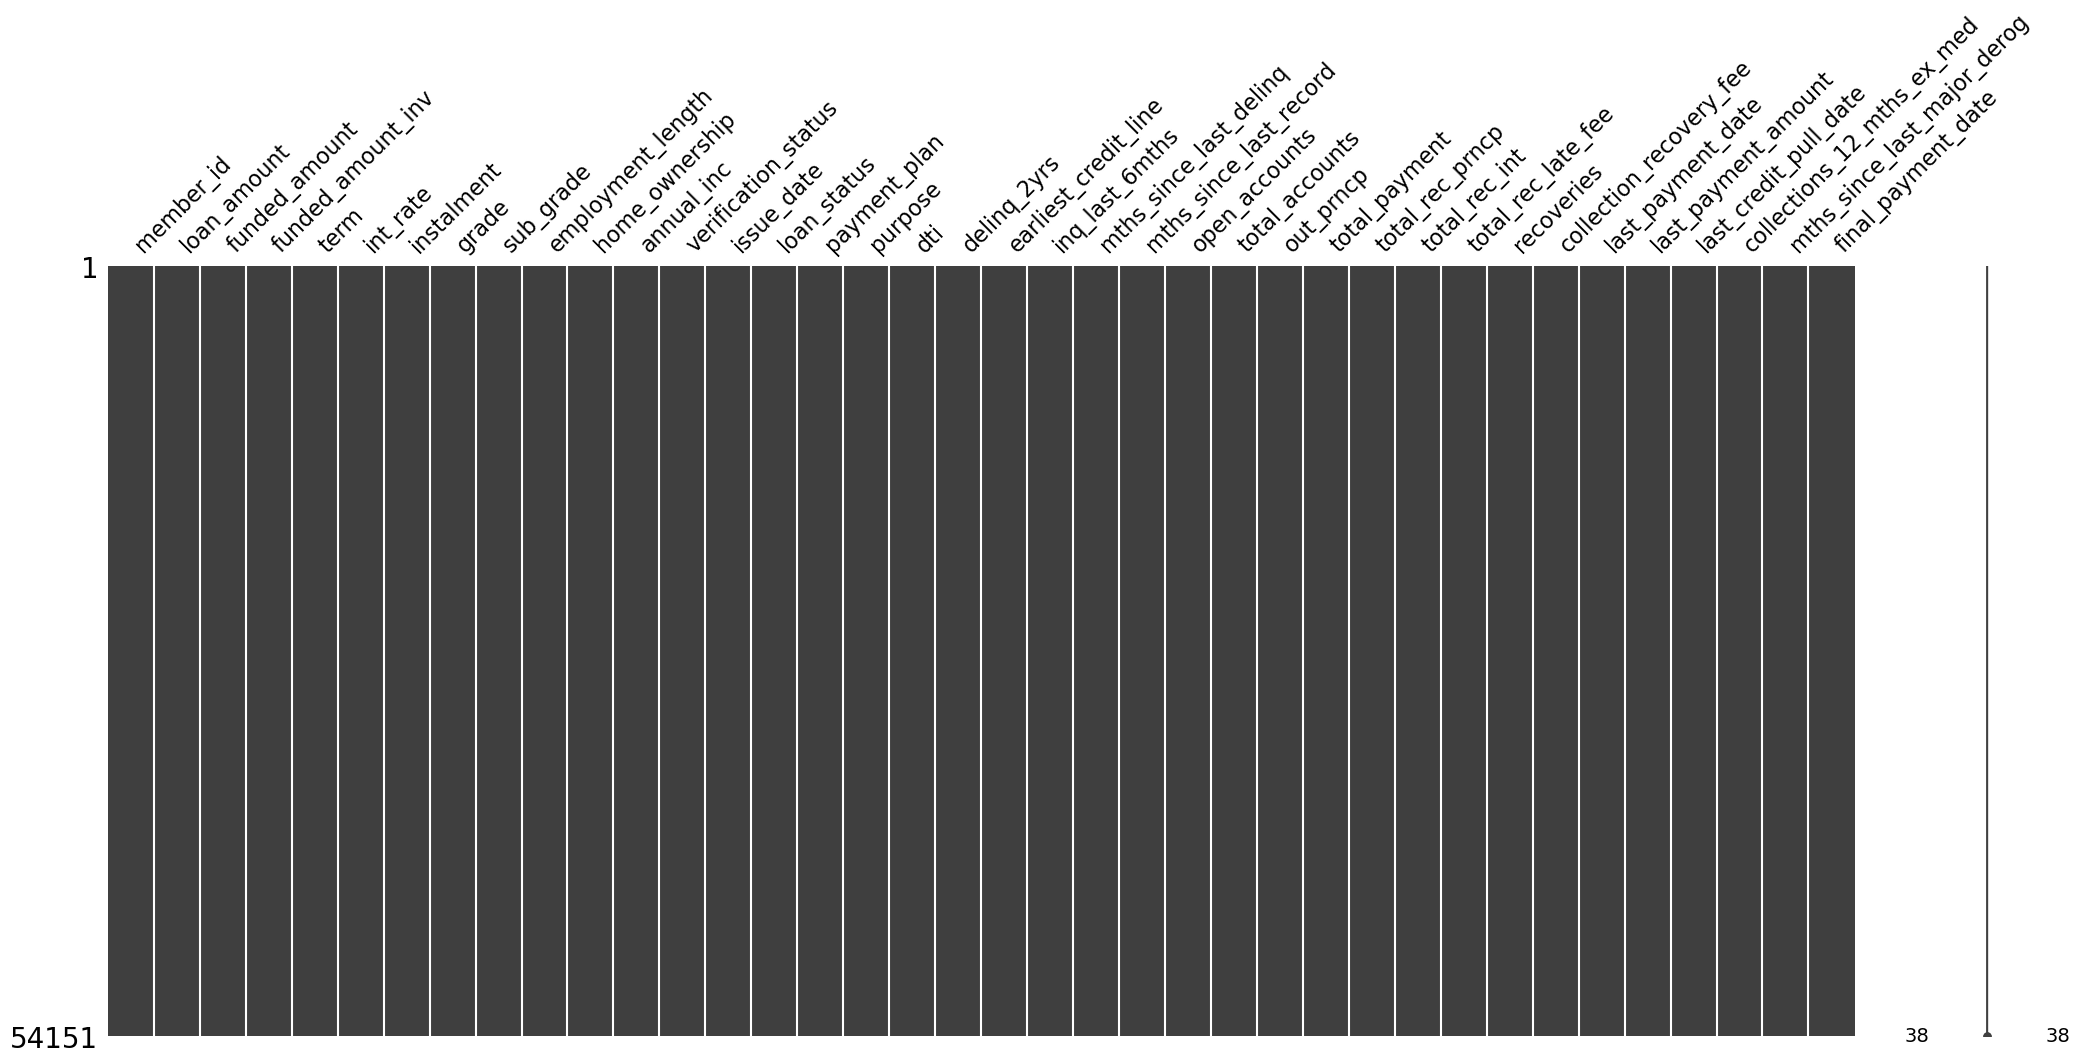

Saving to CSV in dir: c:\Users\prote\exploratory-data-analysis---customer-loans-in-finance/dataset/formatted_loan_data.csv
Completed Save


In [11]:
plt = Plotter(t_form.df)
plt.missing_nulls_vis()

# Save Data
RDSDatabaseConnector.save_to_csv(
    t_form.df, "formatted_loan_data.csv")

# Measure Skew of Data

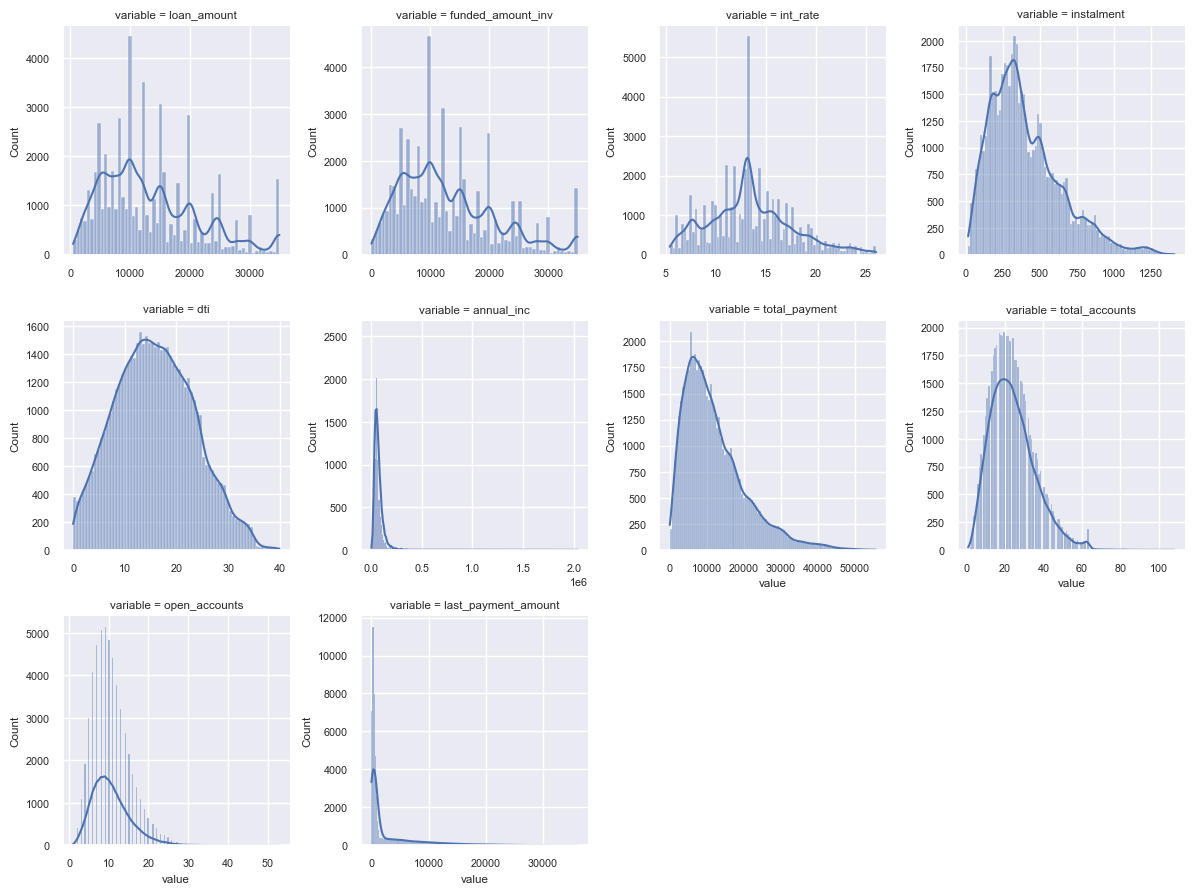

+---------------------+---------------------+
|       Column        |      Skewness       |
+---------------------+---------------------+
|     loan_amount     | 0.8049220181025606  |
|  funded_amount_inv  | 0.8133760847946324  |
|      int_rate       | 0.45661978102982004 |
|     instalment      | 0.9965721690437305  |
|         dti         | 0.18910057534680505 |
|     annual_inc      |  8.717499605870014  |
|    total_payment    | 1.2698752968451772  |
|   total_accounts    | 0.7790400286166349  |
|    open_accounts    | 1.0591835802494733  |
| last_payment_amount | 2.4972203995928135  |
+---------------------+---------------------+


In [12]:

# delinq appears more discrete than continuous so we dont include in skew analysis
numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'annual_inc', 'total_payment', 'total_accounts', 'open_accounts', 'last_payment_amount']

plt.multi_hist_plot(numerical_cols)
Info.skew_data(numerical_cols)

# Data Skew Result
All numerical data has high positive Skew meaning that the values are greatly over represented by outliers. Also the mean and median are much higher than the mode.

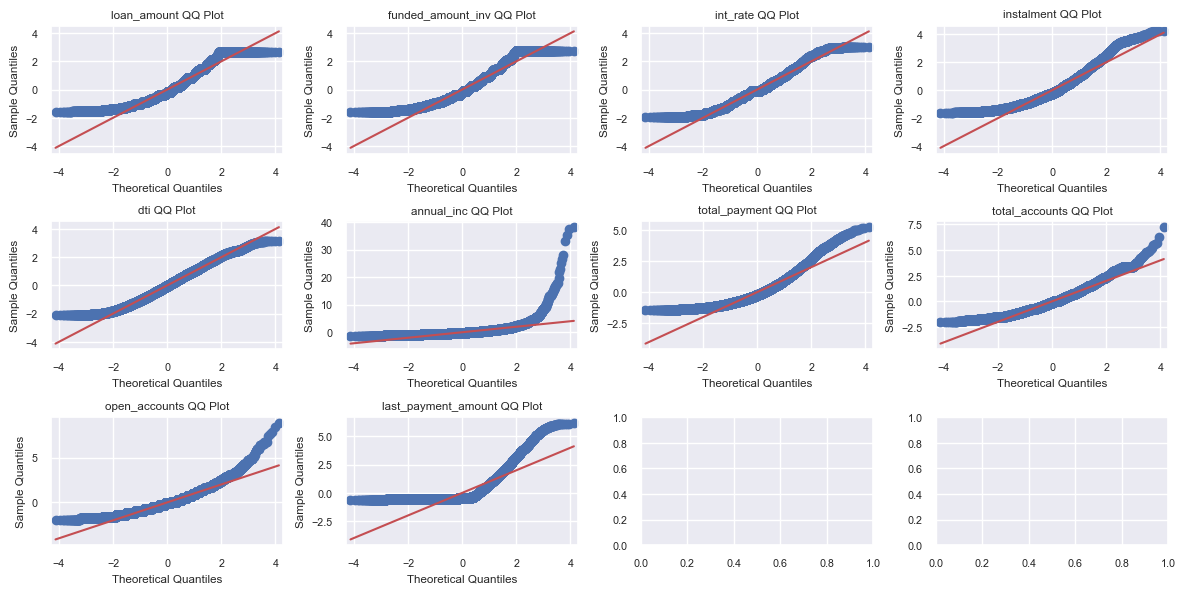

In [13]:
plt.multi_qq_plot(numerical_cols)

info = DataFrameInfo(t_form.df)

right_skewed_cols = ['annual_inc', 'total_payment', 'total_accounts',
                     'last_payment_amount', 'open_accounts', 'instalment', 'funded_amount_inv']

As we can see the majority cols have almost exponential looking outliers

Now the skew values are closer to 0 and we can apply Box cox transform

+---------------------+-----------------------+
|       Column        |       Skewness        |
+---------------------+-----------------------+
|     loan_amount     | -0.04307775783057989  |
|    total_payment    | -0.013814738044390004 |
|     instalment      | -0.020712390195657807 |
|      int_rate       | -0.01335284004413076  |
|         dti         |  -0.1257174261979297  |
|  funded_amount_inv  | -0.052401142306556805 |
|     annual_inc      |  0.1392027966594716   |
|   total_accounts    |  -0.678135510649571   |
|    open_accounts    | -0.47090032482861877  |
| last_payment_amount |  0.12803761707038572  |
+---------------------+-----------------------+


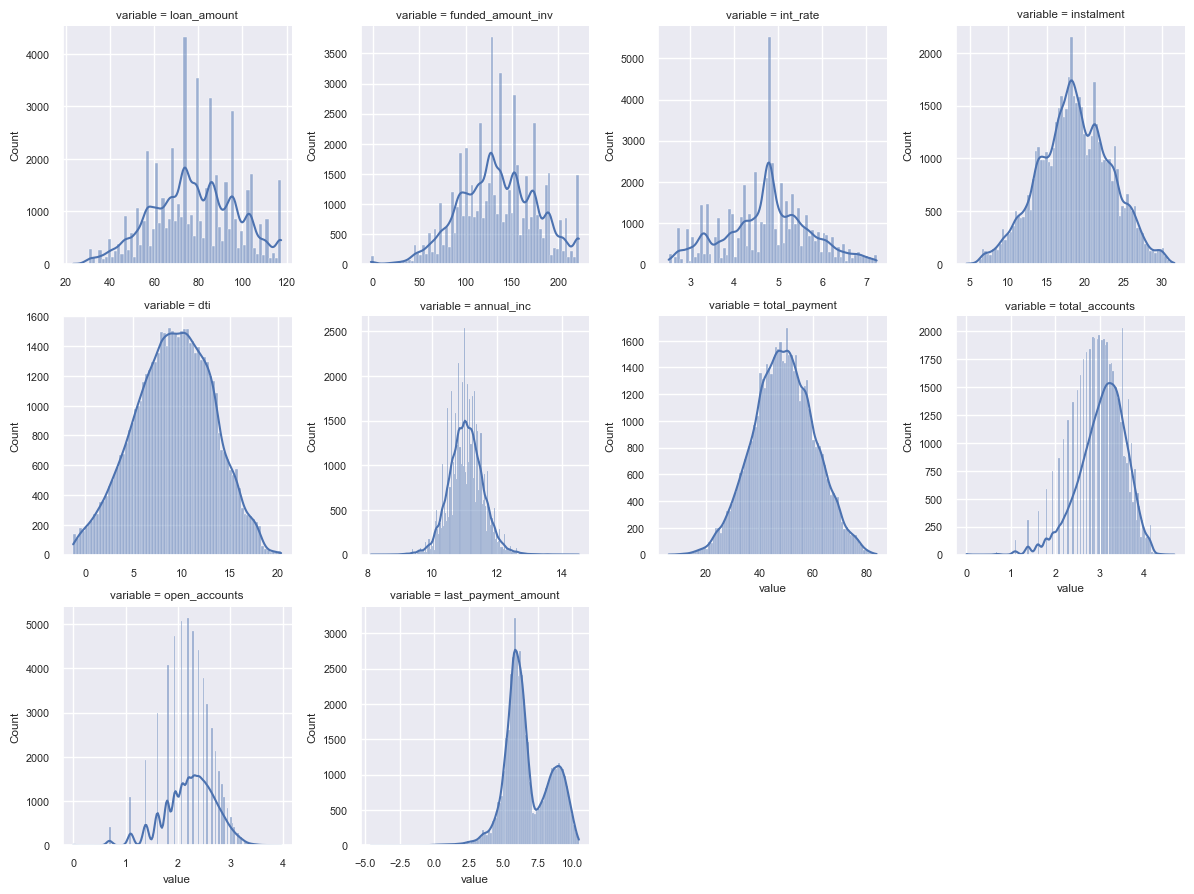

In [14]:
t_form.box_cox_transform(
    ['loan_amount', 'instalment', 'int_rate', 'dti', 'funded_amount_inv', 'total_payment'])

# Reduce impact of outliers
log_transform_cols = ['annual_inc', 'total_accounts',
                      'open_accounts', 'last_payment_amount']

t_form.log_transform(log_transform_cols)

Info.skew_data(
    ['loan_amount', 'total_payment', 'instalment', 'int_rate', 'dti', 'funded_amount_inv', 'annual_inc', 'total_accounts', 'open_accounts', 'last_payment_amount'])


plt.multi_hist_plot(numerical_cols)

Now the data is a lot more normally distributed and prepared for linear-regression, k-nearest neighbours and SVM algorithms. Some results like total_accounts and open_accounts appear more discretely represented.

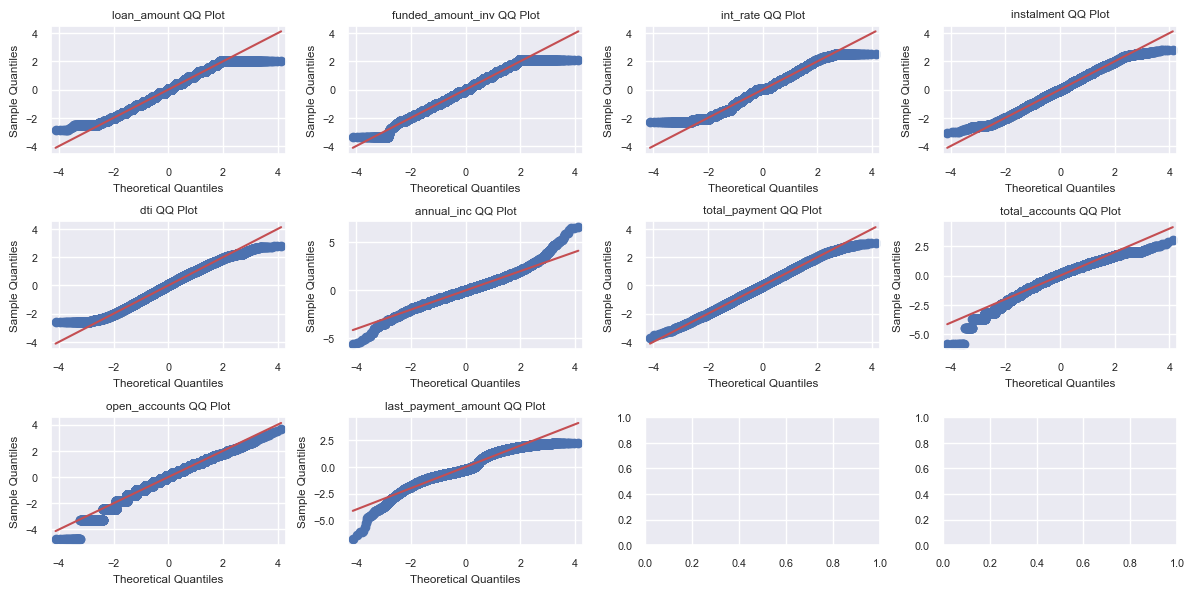

In [15]:
plt.multi_qq_plot(numerical_cols)

# Measure Correlation of data to understand which columns redundant

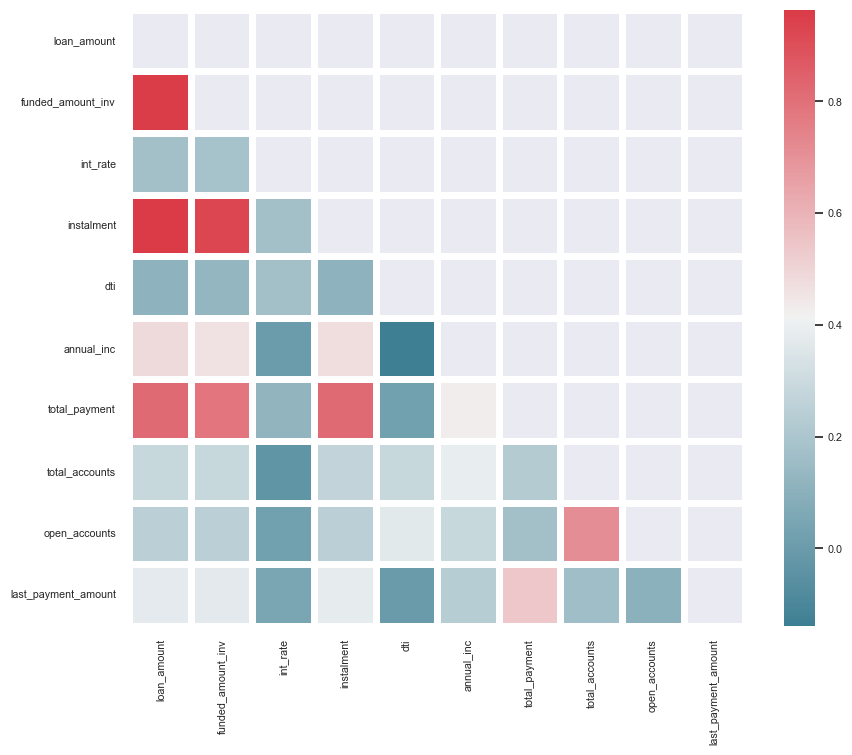

3.704453351841879
Saving to CSV in dir: c:\Users\prote\exploratory-data-analysis---customer-loans-in-finance/dataset/transformed_data.csv
Completed Save


In [16]:
import statsmodels.formula.api as smf

plt.correlated_vars(numerical_cols)

model0 = smf.ols("funded_amount ~ funded_amount_inv", plt.df).fit()


def VIF(r2):
    return 1/(1-r2)


print(VIF(model0.rsquared))
RDSDatabaseConnector.save_to_csv(
    t_form.df, "transformed_data.csv")

# Current State of Loans

1. Summarising what percentage of loans are recovered against investor funding currently.

In [17]:
df = pd.read_csv("./dataset/formatted_loan_data.csv",
                 parse_dates=['issue_date', 'last_payment_date', 'final_payment_date'])

df['final_payment_date'] = df.apply(
    lambda row: row['issue_date'] + DateOffset(months=row['term']), axis=1)
df['total_to_pay'] = df['instalment'] * \
    df['term']

no_nill_invested = df['funded_amount_inv'] != 0

In [18]:
# If nill for funded_amount_inv (investors) use funded_amount (business)
original_df = df[~no_nill_invested]

df = df[no_nill_invested]

# Check If the loan is recovered
df['recovered_ratio'] = (
    df['total_payment'] / df['funded_amount_inv'])

original_df['recovered_ratio'] = (
    original_df['total_payment'] / df['funded_amount'])

# Recombine dataframes now with ratio
df = pd.concat([df, original_df], ignore_index=True)

# Convert to index for grouping
df['last_payment_date'] = pd.DatetimeIndex(df['last_payment_date'])

# Check if loan is recovered
df['recovered'] = df['recovered_ratio'].ge(1)
recovered_loans = df['recovered'] == True

# Filter by recovered loans
recovered_loan_df = df[recovered_loans]

percent_of_loans_recovered = round(len(recovered_loan_df) / len(df) * 100, 2)

print(f"Percent of Loans Currently Recovered: {percent_of_loans_recovered}%")

Percent of Loans Currently Recovered: 55.98%


2. Project the query 6 months in the future based on instalments per month

In [19]:
# Check what Further can be recovered in 6 months
# make sure
finished_term_mask = df['final_payment_date'] > df['last_payment_date']
future_df = df.loc[~recovered_loans & finished_term_mask].copy()


prediction_df = df.loc[~recovered_loans & finished_term_mask].copy()
prediction_recovered_df = df.loc[recovered_loans].copy()

prediction_df['recovered'] = 0
future_df['6m_future_total_payment'] = future_df['total_payment'] + \
    (future_df['instalment'] * 6)


future_df['recovered'] = (
    future_df['6m_future_total_payment'] / df['funded_amount_inv']).ge(1)


recovered_loans = future_df['recovered'] == True
recovered_loan_df_6m_future = future_df.loc[recovered_loans]


percent_of_loans_recovered = round(
    len(recovered_loan_df_6m_future) / len(df) * 100, 2)


print(f"Percent of Loans Currently Recovered: {percent_of_loans_recovered}%")

Percent of Loans Currently Recovered: 15.36%


# Simulating and Graphing the future 6 month payments

3. As we can see an additional 15% of loans are assumed to be recovered based of instalment payments, so to visualise that insight we create simulated data and graph it.

### Thought Process
I initially seperated the dataframe into *recovered* and *unrecovered* slices to find out what percentage of the *unrecovered dataframe* could be paid off in 6 months.

So I used what I already had and:

1. Made all the last payment dates the latest date
2. Sliced only the months with the latest date ( All the date initially)
3. Added total_payment and instalment and increment the month by 1 to get simulated next month payment
4. The next iteration would select this last slice because its the latest date and continue until 6 months.

(Essentially like a window function per dates)

I did this because I wanted to show the cumulative sum of percentage change over month in recovered loans to visualise in a graph


In [20]:
prediction_df = prediction_df[[
    'last_payment_date', 'total_payment', 'instalment', 'funded_amount_inv', 'member_id', 'recovered']]


def add_months(df, col, nmonths):
    df[col] = df[col] + DateOffset(months=nmonths)


def add_nums(df, col, col_2):
    df[col] = df[col] + df[col_2]


def copy_and_mask_df(df, mask):
    return df.loc[mask].copy()


# # Simulate payments and dates
months_to_predict = 6

prediction_df.sort_values(
    by='last_payment_date', ascending=False, inplace=True)

# reset all values to be the latest date payment was made
prediction_df['last_payment_date'] = prediction_df['last_payment_date'].iloc[0]

# prediction_df
for _ in range(months_to_predict):
    latest_date = prediction_df['last_payment_date'].max()

    mask = (prediction_df['last_payment_date'] == latest_date) & (
        prediction_df['recovered'] == False)

    copy_df = copy_and_mask_df(prediction_df, mask)

    add_nums(copy_df, 'total_payment', 'instalment')
    add_months(copy_df, 'last_payment_date', 1)

    copy_df['recovered'] = (
        copy_df['total_payment'] / copy_df['funded_amount_inv']) >= 1

    prediction_df = pd.concat([prediction_df, copy_df], ignore_index=True)


min_date = prediction_df['last_payment_date'].min()
prediction_df = prediction_df[prediction_df['last_payment_date'] > min_date]
prediction_df = prediction_df[prediction_df['recovered'] == True]

In [21]:
complete_df = pd.concat(
    [prediction_recovered_df, prediction_df], ignore_index=True)

# Group by month to count amount recovered that month
filtered_df = complete_df .set_index('last_payment_date').groupby(
    [pd.Grouper(freq="M")])['recovered'].count().reset_index()

# Sort by date
filtered_df.sort_values(
    by='last_payment_date', ascending=True, inplace=True)

# Cumulative sum the percentage recovered per month ( recovered count / total recovered + unrecovered count )
filtered_df['cumulative_sum'] = filtered_df['recovered'].apply(
    lambda x: x / (len(df)) * 100).cumsum()

filtered_df

,last_payment_date,recovered,cumulative_sum
0,2014-01-31,3,0.005540
1,2014-02-28,2,0.009233
2,2014-03-31,5,0.018467
3,2014-04-30,7,0.031394
4,2014-05-31,13,0.055401
...,...,...,...
98,2022-03-31,1154,59.564920
99,2022-04-30,1437,62.218611
100,2022-05-31,1731,65.415228
101,2022-06-30,1674,68.506583


As we can see whe have the expected final sum based on previously calculated:
Percent of Loans Currently Recovered: 55.98% + Percent of Loans Currently Recovered: 15%

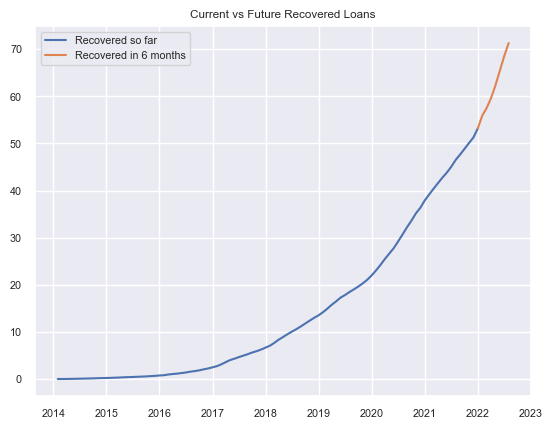

In [22]:
mask_original_data = filtered_df['last_payment_date'] <= min_date
mask_future_data = filtered_df['last_payment_date'] >= min_date - \
    DateOffset(months=1)

original_df = filtered_df.loc[mask_original_data]
future_df = filtered_df.loc[mask_future_data]

pyplot.plot(original_df['last_payment_date'],
            original_df['cumulative_sum'], label='Recovered so far')
pyplot.plot(future_df['last_payment_date'],
            future_df['cumulative_sum'], label='Recovered in 6 months')

pyplot.legend()
pyplot.title('Current vs Future Recovered Loans')
pyplot.show()

# Calculating Loss

Via column *loan_status* on loans that are charged_off

In [23]:
df = pd.read_csv("./dataset/formatted_loan_data.csv",
                 parse_dates=['issue_date', 'last_payment_date', 'final_payment_date'])


charged_off_mask = df['loan_status'] == 'Charged Off'



charged_off_df = df.loc[charged_off_mask].copy()



prc_charged_off = round((len(charged_off_df) / len(df)) * 100, 2)



print(f"Percentage Charged Off : {prc_charged_off}%")

Percentage Charged Off : 10.16%


In [24]:
charged_off_df['expected_total_payment'] = charged_off_df['instalment'] * \
    charged_off_df['term']

total_paid = round(sum(charged_off_df['total_payment']), 2)

total_required = round(sum(charged_off_df['expected_total_payment']), 2)

prc_paid_off = round((total_paid / total_required) * 100, 2)

print(f"Paid Towards Charged Off: {total_paid}")
print(f"Required to be paid: {total_required}")
print(f"Percentage paid off: {prc_paid_off}%")

Paid Towards Charged Off: 37305414.56
Required to be paid: 93259304.04
Percentage paid off: 40.0%


In [25]:
# Instalments already include interest

missed_out_revenue = round(total_required - total_paid, 2)
prc_lost = round((missed_out_revenue / total_required) * 100, 2)

print(f"Missed out/ Increase in revenue: ${missed_out_revenue}")
print(f"Percentage Lost: {prc_lost}%")

Missed out/ Increase in revenue: $55953889.48
Percentage Lost: 60.0%


### Possible Loss

In [26]:
df['payments_made'] = df['total_payment'] / \
    df['instalment']
df['months_left_to_pay'] = df['term'] - \
    df['payments_made']

late_mask = df['loan_status'].str.contains('Late')

late_df = df.loc[late_mask].copy()

prc_behind = round((len(late_df) / len(df)) * 100, 2)

print(f"Percentage of Late Loans: {prc_behind}%")

Percentage of Late Loans: 1.27%


In [27]:
late_df['amount_left_to_pay'] = late_df['months_left_to_pay'] * \
    late_df['instalment']

projected_loss = round(late_df['amount_left_to_pay'].sum(), 2)

print(f"Projected Loss if Switched to Charged Off: ${projected_loss}")

Projected Loss if Switched to Charged Off: $6223299.73


In [28]:
prc_late_and_charged_off = round(
    ((len(late_df) + len(charged_off_df)) / len(df)) * 100, 2)

print(
    f"Percentage of late and charged_off customers: {prc_late_and_charged_off}%")

Percentage of late and charged_off customers: 11.43%


# Indicator of Loss

Analysing possible indicators that a customer will not pay a loan

Highlight Data to Check
1. Loan Grade
2. Reason
3. DTI

First im going to convert the categorical columns to numerical representation to apply to correlation matrix and chi-squared test

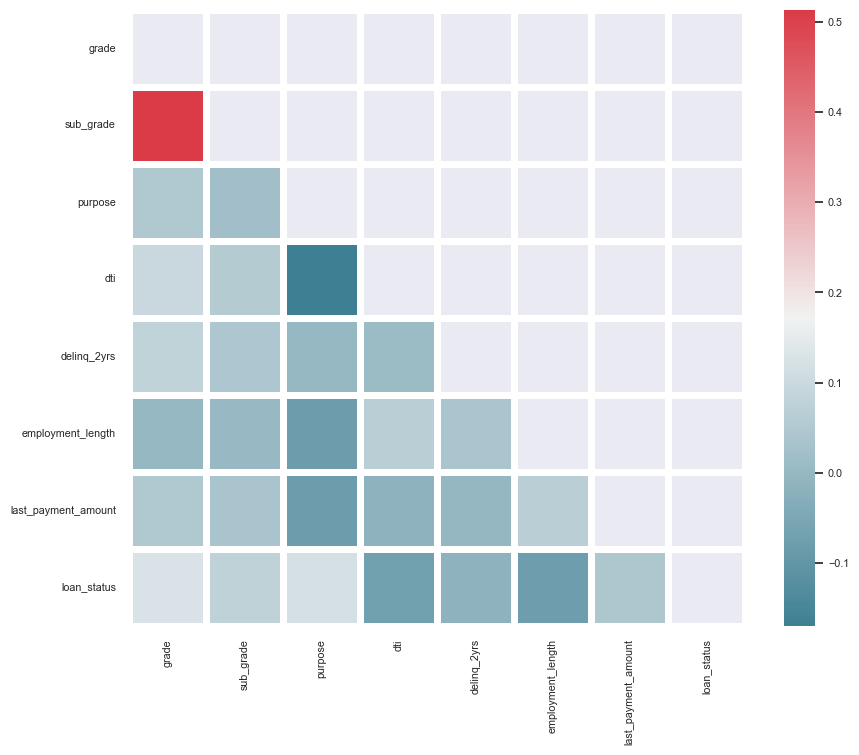

In [44]:
late_and_charged_off = pd.concat([late_df, charged_off_df])

categorical_cols = df.select_dtypes(
    exclude=np.number).columns.tolist()

_, b = pd.factorize(df[categorical_cols].values.ravel('F'))

df[categorical_cols] = df[categorical_cols].apply(
    lambda x: pd.Categorical(x, b).codes)


indicator_cols = ['grade', 'sub_grade', 'purpose',
                  'dti', 'delinq_2yrs', 'employment_length', 'last_payment_amount', 'loan_status']

plt = Plotter(df)
plt.correlated_vars(indicator_cols)

In [47]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['grade'], df['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 3768.3508067318576
p-value = 0.0


# Loss prediction result


### Correlation Matrix
As we can see the correlation matrix shows little significance between loan_status and any other forseen factors so we are not going to take a subset of charged off customers to further dig into the data.

### Chi-Squared Test
Chi-Squared Test shows an extremely high statistic and a p-value of 0 suggesting that there is significant difference between any potential indicator columns